# Toxic Comment Detector

In [18]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from statistics import mean

## Import Data Files

In [19]:
train_text = pd.read_csv("include/train.csv", index_col=False)
train_text.reset_index(drop=True)
test_text = pd.read_csv("include/test.csv", index_col=False)
sample_submission = pd.read_csv("include/sample_submission.csv", index_col=False)
test_labels = pd.read_csv("include/test_labels.csv", index_col=False)

train_text.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Format data frames

In [4]:
X = train_text['comment_text']
y = train_text.drop(['id'], axis=1)
y = y.drop(['comment_text'], axis=1)
X_val = test_text['comment_text']

In [5]:
#Looking at the distribution of traget variables
y_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
train_text[y_cols].apply(pd.Series.value_counts, args = (True, True, False, None, False))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904156,0.990004,0.947052,0.997004,0.950636,0.991195
1,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805


## Plot the data

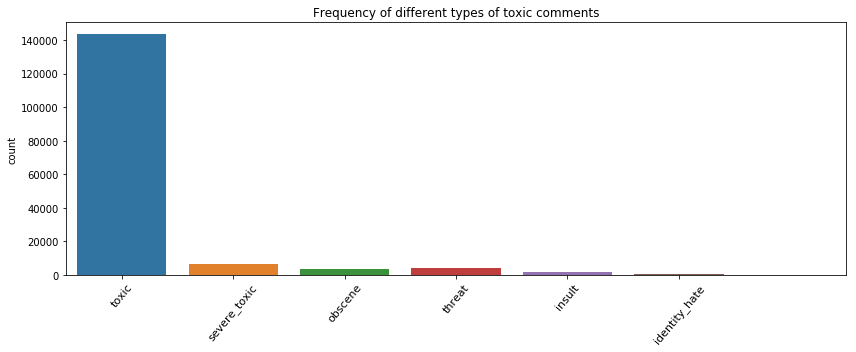

In [6]:
# fig, axes = plt.subplots(figsize = (32,8))
fig, axes = plt.subplots(figsize = (12,5))
sns.countplot(y.sum(axis = 1))
# NOTE: axis = 1 adds everything along columns and axis = 0 adds everything along rows
axes.set_xticks(range(6)) # Have to do this to work around a bug
axes.set_xticklabels(y.columns, rotation = 50, ha = "center", fontsize = 11)
plt.title("Frequency of different types of toxic comments")
plt.tight_layout()
plt.show()

## Split the data into training and validation sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 101)
print("Training set size: ", X_train.shape, y_train.shape)
print("Testing set size: ", X_test.shape, y_test.shape)

Training set size:  (111699,) (111699, 6)
Testing set size:  (47872,) (47872, 6)


## Basic  Preprocessing

In [11]:
# Remove punctuation marks and digits
# Stop words remoe words such as: in, the, so, of etc. that don't help us determine the y labels
stop_words = ENGLISH_STOP_WORDS
def clean(doc):
    doc = "".join([special_char for special_char in doc if special_char not in string.punctuation and not special_char.isdigit()])
    doc = " ".join([word for word in doc.split() if word not in stop_words])
    return doc.lower() # Make all words lower case

## Creating bag of words (CBOW)

In [12]:
# Creating bag of words with a maximum of 5000 frequently used words

word_vect = CountVectorizer(max_features = 5000, preprocessor = clean)

In [13]:
# Let's find the number of occurances of the 5000 frequenct words
X_train_freq_words = word_vect.fit_transform(X_train)
X_test_freq_words = word_vect.fit_transform(X_test)

X_freq_words_full_training = word_vect.fit_transform(X)
X_freq_words_full_testing = word_vect.fit_transform(X_val)

print("The number of times the 5000 most frequent words appear in the training dataset is: " , X_train_freq_words.shape)
print("The number of times the 5000 most frequent words appear in the validation dataset is: " , X_test_freq_words.shape)
# print("Frequent words in training data: ", pd.DataFrame(X_train_freq_words.A[:], columns = word_vect.get_feature_names()))
# print("\nfrequent words in testing data: ", pd.DataFrame(X_test_freq_words.A[:], columns = word_vect.get_feature_names()))

The number of times the 5000 most frequent words appear in the training dataset is:  (111699, 5000)
The number of times the 5000 most frequent words appear in the validation dataset is:  (47872, 5000)


## Create a multi-output classifier (Multinomial Naive Bayes Model)

In [14]:
NB_classifier = MultiOutputClassifier(MultinomialNB())

NB_trained_model = NB_classifier.fit(X_train_freq_words, y_train)
target_prediction = NB_trained_model.predict(X_test_freq_words)

prediction_accuracy = accuracy_score(y_test, target_prediction)
print("The accuracy score on a small section of the training data is: ", prediction_accuracy)

The accuracy score on a small section of the training data is:  0.8138160093582888


## Performance on the test data

In [15]:
# ROC: Receiver Operating Characteristic is a graph showing the preformance of a classification model at all classification thresholds
# AUC: measures the entired two-dimensional area under the entire ROC curve.
# ROC - AUC score: indicates the degree of separability/distintion or intermingling/crossover between the predictions of the two classes
# Higher the ROC-AUC score, lower the crossover and better the seperation between the classes

def calc_roc_auc(y_test, target_predict):
    aucs = []
    # Calculate the ROC - AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col], target_predict[:,col]))
    return aucs

results = []
y_test_result = y_test.values
target_predict = np.transpose(np.array(NB_trained_model.predict_proba(X_test_freq_words))[:,:,1])
mean_auc = mean(calc_roc_auc(y_test_result, target_predict))
results.append(mean_auc)

print("The mean AUC using Naive Bayes Model is: ", mean_auc)

The mean AUC using Naive Bayes Model is:  0.6319471301666983


## Predicting on the Test data

In [16]:
# Create representation using CBOW and count vectorizer
X_freq_words_full_testing = word_vect.fit_transform(X_val)
# Predict the probability values of the y labels
y_prediction = np.transpose(np.array(NB_trained_model.predict_proba(X_freq_words_full_testing))[:,:,1])
# Merge the test_text and the sample submission files
df_test = pd.merge(test_text, sample_submission, on = 'id')
# Create the y-labels
y_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# Input the prediction values into the dataframe
df_test[y_cols] = y_prediction
# drop the comment_text column as it is not a part of the sample submission
df_test.drop(['comment_text'], axis = 1, inplace = True)
# Write the values in the dataframe into a CSV file
df_test.to_csv("sample_submission.csv", index = False)
print("Data saved in the csv file")

Data saved in the csv file
